# NLP Advanced Applications: Introduction to Retrieval-augmented Generation (RAG)

Overall, a RAG system, which stands for Retrieval Augmented Generation, combines retrieval and generation capabilities to enhance language understanding and generation. It is composed of several key components that work together to deliver these capabilities:


- Vector database: This is a database that stores the documents as embeddings to later allow them to be queried for relevant information. It serves as the knowledge base for the RAG system.

- Retriever (Semantic Search): The retriever is responsible for searching the vector database to find the most relevant documents based on the semantic similarity between the input query and the documents.

- Reader (LLM): Once the relevant documents are retrieved, the reader processes this information along with the original query to generate a coherent and contextually relevant response through an LLM model. It involves prompt construction to define the LLM input and post-processing functions to parse the answer.

- Framework: This layer manages the interaction between the retriever and the reader, ensuring the efficient operation of the RAG system .

- Interface (Client): The interface is the user-facing component that allows interaction with the RAG system, typically through a conversational interface or an API .

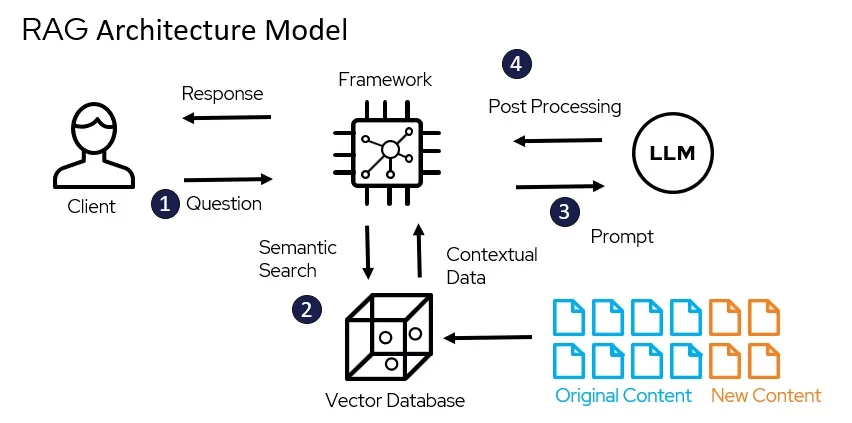



## Pros and Cons of Using Retrieval-Augmented Generation (RAG) Systems

RAG systems have become increasingly prevalent in today's landscape and are at the forefront of NLP technology, enabling the advancement of contemporary generative AI applications. Below, we list some pros and cons:

**Pros:**
1. **Access to External Knowledge:** RAG systems can access vast amounts of external knowledge, allowing them to provide rich contextual information.
2. **Increased Traceability:** RAG systems excel in recalling relevant snippets of information, enabling them to provide more comprehensive and traceable responses.
3. **Reduced Hallucinations:** By retrieving relevant knowledge from external sources, RAG systems can help reduce hallucinations and generate more accurate and factual information.
4. **Continual Information Gathering:** RAG systems allow for continually gathering information throughout the generation process, which is essential for generating long texts.

**Cons:**
1. **Complex Implementation:** The initial setup and configuration of RAG systems may require technical expertise, especially for organizations without an existing infrastructure.
4. **Potential Oversimplification:** In complex project scenarios, the simplicity of RAG status may lead to an oversimplification of problems, overlooking nuanced underlying issues.
5. **Adequate Retrieval Mechanism:** Proper implementation of RAG systems requires an efficient and effective mechanism to retrieve the correct context. Improperly implemented RAG tools can negatively impact responses by injecting irrelevant information or surfacing sensitive information that should have been kept confidential.

I hope this provides a comprehensive overview, now, it is time to start building our amazing RAG system!

## 0. Install and import libraries

Let's install all the libraries we will use during the lab!

>*Note*: that we will make use of the `langchain` framework to set and orcherstrate the key components of our RAG system by using other libraries such as, for example `transformers`, `sentence-transformers`. However, other alternatives are legitimate, for example, [haystack](https://haystack.deepset.ai/) or [llama-index](https://www.llamaindex.ai/), check them out!

In [ ]:
# Install libraries
!pip install --upgrade pip
!pip install langchain
!pip install langchain-community
!pip install langchain_huggingface
!pip install arxiv
!pip install pypdf
!pip install spacy
!pip install sentence-transformers
!pip install faiss-cpu
!pip install transformers
!pip install bitsandbytes
!pip install accelerate
!pip install huggingface_hub
!pip install scipy
!pip install pandas
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 117.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from typing import List
from pprint import pprint

**Important**: define your HuggingFace API token to access the models following the instruction in the [link](https://huggingface.co/docs/hub/en/security-tokens).

In [ ]:
import os
HUGGINGFACEHUB_API_TOKEN = "YOUR_HF_API"
# HF_API_TOKEN = "YOUR_HF_API_TOKEN"
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

## Download and extract data from PDFs

We start with the famous BERT paper very recent survey on LLMs titles "[Devlin, Jacob, et al. "Bert: Pre-training of deep bidirectional transformers for language understanding." arXiv preprint arXiv:1810.04805 (2018).](https://arxiv.org/abs/1810.04805)".

First, we download it directly from the ArXiv repo.

In [ ]:
# donwload data
import arxiv

paper_id = "1810.04805"
paper = next(arxiv.Client().results(arxiv.Search(id_list=[paper_id])))
# Download the PDF to the PWD with a filename.
paper_file = "bert.pdf"
paper.download_pdf(filename=paper_file)

'./bert.pdf'

Then, we use parse the paper with the `PyPDF` library and inspect its content.

> *Note*: other libraries are also suitable for the purpose, check the documentation [here](https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf)

In [ ]:
# Parse data from PDFs
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader(paper_file)

# Inspect the content extracted
content_pages = [page.page_content for page in loader.load_and_split()]

In [ ]:
content_pages[:2]

['BERT: Pre-training of Deep Bidirectional Transformers for\nLanguage Understanding\nJacob Devlin Ming-Wei Chang Kenton Lee Kristina Toutanova\nGoogle AI Language\n{jacobdevlin,mingweichang,kentonl,kristout}@google.com\nAbstract\nWe introduce a new language representa-\ntion model called BERT, which stands for\nBidirectional Encoder Representations from\nTransformers. Unlike recent language repre-\nsentation models (Peters et al., 2018a; Rad-\nford et al., 2018), BERT is designed to pre-\ntrain deep bidirectional representations from\nunlabeled text by jointly conditioning on both\nleft and right context in all layers. As a re-\nsult, the pre-trained BERT model can be ﬁne-\ntuned with just one additional output layer\nto create state-of-the-art models for a wide\nrange of tasks, such as question answering and\nlanguage inference, without substantial task-\nspeciﬁc architecture modiﬁcations.\nBERT is conceptually simple and empirically\npowerful. It obtains new state-of-the-art re-\nsul

## Processing and cleaning of the extracted text from PDF

Notice how the previously extracted raw text may need some processing and cleaning steps. In fact, properly processing and cleaning the extracting content is fundamental to improve the retrieved information and, consequently, the quality of the final answer. For example, extracting either too short or too long texts may be an issue for most of the sentence embeddings that are usually trained with a specific text length. In general, a good length balance is crucial. Moreover, depending on the raw data format, parsing methods may introduce errors in the extracted text.

The following exercises will delve into these topic to make you understand their importance.




### Exercise 1: Chunking in smaller segments

From the previous parsing step, we see that the extracted content consists of very long chunks of text that span across different paragraphs

**GOAL**: Implement a function `split_into_chunks` to chunk the content in fine-grained chunks of approximately 1000 character size. Then, use the function `check_max_len_dist()` to make sure the maximum lenght of chunks is less than 1000.

>*Hint*: use the Spacy class `SpacyTextSplitter` through the `langchain` library: https://python.langchain.com/docs/integrations/providers/spacy

> *Bonus*: Visually understand chunking: https://huggingface.co/spaces/m-ric/chunk_visualizer


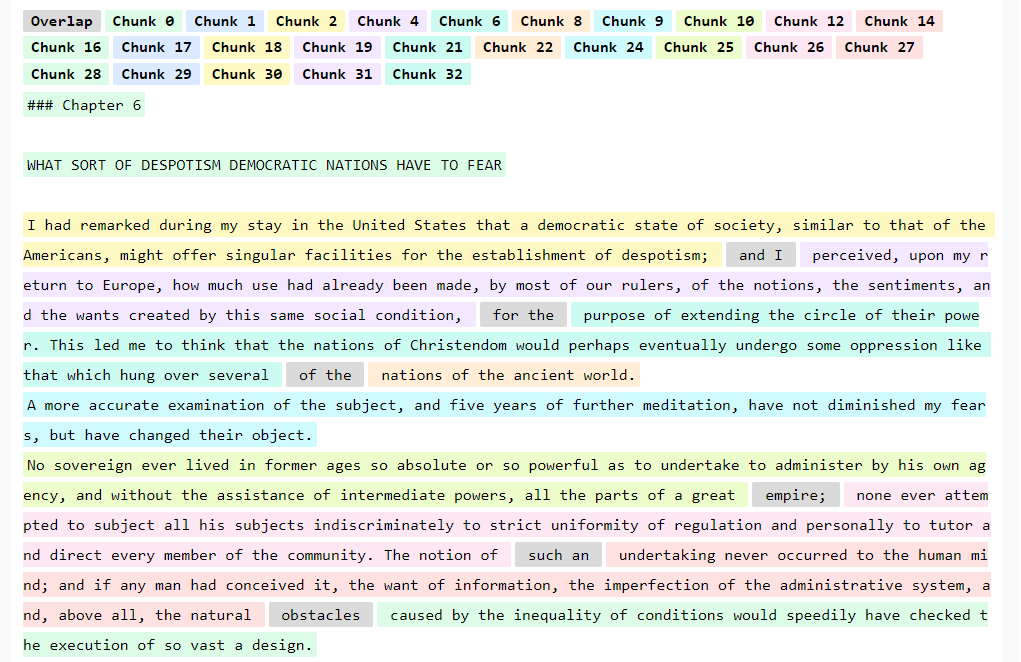



In [ ]:
from langchain.text_splitter import SpacyTextSplitter

def split_into_chunks(content_pages: List[str], chunk_len: int):
  # TODO: Use splitter to return chunks of text of maximum length 1000
  text_splitter = SpacyTextSplitter(chunk_size=1000) ## text_splitter = ...

  document_chunks = []
  for content_pages in content_pages:
    texts = text_splitter.split_text(content_pages)
    document_chunks.extend(texts)
  return document_chunks

In [ ]:
# check if the result is correct
from statistics import mean
def check_max_len_dist(chunks: List[str], chunk_len=1000) -> None:
  mean_chunk_len =  round(mean(len(chunk) for chunk in chunks))
  max_chunk_len =  max(len(chunk) for chunk in chunks)
  assert max_chunk_len <= 1000, ValueError(f"Maximum chararacter length is greater than {chunk_len}")
  print(f"Average length: {mean_chunk_len} chars\nMaximum length: {max_chunk_len} chars")

document_chunks = split_into_chunks(content_pages, 1000)
check_max_len_dist(document_chunks)

/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/usr/local/lib/p

Average length: 843 chars
Maximum length: 996 chars


In [ ]:
document_chunks[:2]

['BERT: Pre-training of Deep Bidirectional Transformers for\nLanguage Understanding\nJacob Devlin Ming-Wei Chang Kenton Lee Kristina Toutanova\nGoogle AI Language\n{jacobdevlin,mingweichang,kentonl,kristout}@google.com\nAbstract\nWe introduce a new language representa-\ntion model called BERT, which stands for\nBidirectional Encoder Representations from\nTransformers.\n\nUnlike recent language repre-\nsentation models (Peters et al., 2018a; Rad-\nford et al., 2018), BERT is designed to pre-\ntrain deep bidirectional representations from\nunlabeled text by jointly conditioning on both\nleft and right context in all layers.\n\nAs a re-\nsult, the pre-trained BERT model can be ﬁne-\ntuned with just one additional output layer\nto create state-of-the-art models for a wide\nrange of tasks, such as question answering and\nlanguage inference, without substantial task-\nspeciﬁc architecture modiﬁcations.\n\n\nBERT is conceptually simple and empirically\npowerful.',
 'BERT is conceptually simpl

### Exercise 2: Cleaning texts
Moreover, we spot some error patterns that indicate the text may be not "clean enough" to accurately retrieve information. Indeed, we identify some errors we could easily fix, such as:

1. Several `\n` characters due to pagination
2. Several `-\n` due to wrong words splitting across pages
3. Double empty spaces `"  "`

**GOAL:** Implement a simple function called `clean_chunks` to clean the patterns above. Then, manually inspect the cleaned content to check the quality of the text has improved.

In [ ]:
def clean_chunks(document_chunks: List[str]) -> List[str]:
  # TODO: Implement a simple cleaning function to remove the errors listed above
  document_chunks_cleaned = [] ## document_chunks_cleaned = ...
  for chunk in document_chunks:
    chunk_clean = chunk.replace("-\n", "").replace("\n", " ").replace(r"  ", " ").strip()
    document_chunks_cleaned.append(chunk_clean)

  return document_chunks_cleaned

In [ ]:
# Manually check the difference with the extracted raw text
document_chunks_cleaned = clean_chunks(document_chunks)
document_chunks_cleaned[:2]

['BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding Jacob Devlin Ming-Wei Chang Kenton Lee Kristina Toutanova Google AI Language {jacobdevlin,mingweichang,kentonl,kristout}@google.com Abstract We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be ﬁnetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspeciﬁc architecture modiﬁcations.  BERT is conceptually simple and empirically powerful.',
 'BERT is conceptually simple and empirically powerful. It obtains new st

## Semantic search with vector database
Semantic search with a vector database is a cutting-edge technology that revolutionizes the way we search for information. Instead of relying solely on keyword matching, it leverages the power of machine learning and natural language processing to understand the meaning behind the search query. By representing words and phrases as vectors in a high-dimensional space, the semantic search engine can calculate the similarity between the query and the database entries, providing more accurate and relevant results. This approach enables users to find information based on context and intent, rather than just matching keywords.

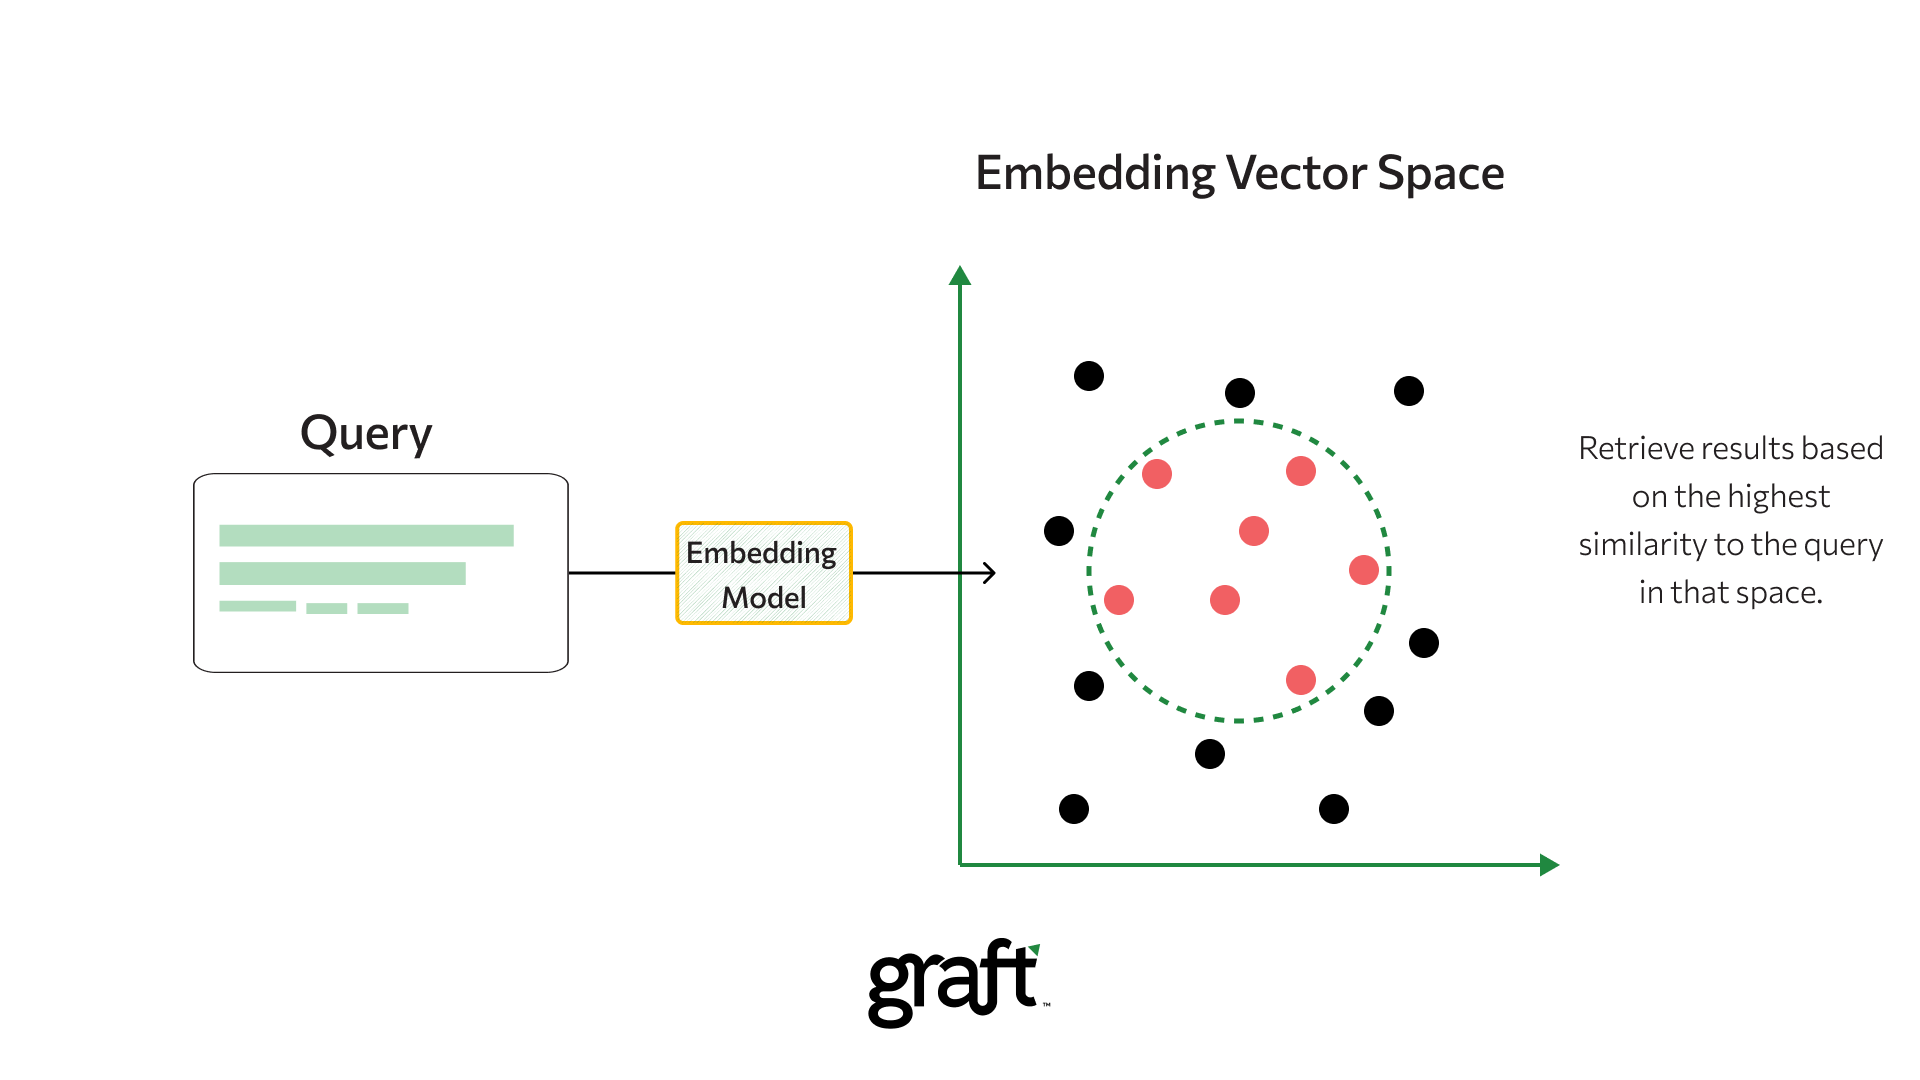

### Compute text embeddings

First, we need to compute text embeddings for each document chunk we extracted from PDF. The resulting vectors contain the semantic information that allow us to perform semantic search with a search query. We use sentence transformers models to compute text embeddings, specifically, we select the `all-mpnet-base-v2` model from the HuggingFace HUB due to its high performance in many retrieval scenarios.

> *Note*: depending on your use-case, you could consider other sentence transformers embeddings models. The sentence transformers library provide a lot of them on the [HF HUB](https://huggingface.co/sentence-transformers)

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
embedding_model = "all-mpnet-base-v2"
embeddings = HuggingFaceEmbeddings(model_name=embedding_model)


<ipython-input-12-4807adbbbb10>:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=embedding_model)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(

### Index embeddings with a vector database
Indexing vectors into a vector database refers to the process of mapping vectors to a data structure within the database to enable faster searching and retrieval of similar vectors.

In our case, we use the `FAISS` library through the `langchain` framework since it perform fast semantic search suitable for large-scale vector databases.

> *Note*: indexing could take some minutes, be patient!

In [ ]:
from langchain_community.vectorstores import FAISS
db = FAISS.from_texts(document_chunks_cleaned, embeddings)

### Exercise 3: Retrieval with semantic search

**GOAL:** Implement a function called `retrieve_context` to perform semantic search on the vector database to retrieve the `top-k` chunks similar to a given query. Aggregate the result in a single `context` that will be later used as input for the LLMs. Then, check the resulting context and qualitatively assess if the information is relevant (e.g., try to understand if there's enough information to answer the question below).

> Hints:
1. read the documentation of the `FAISS` vector database: https://python.langchain.com/docs/integrations/vectorstores/faiss
2. aggregate using `\n\n` delimiters to better separate different contents inside the context

In [ ]:
# Retrieve context similar to a query using semantic search
def retrieve_context(question: str, vector_database: FAISS, topk: int) -> str:
  # TODO: Retrieve text with semantic similarity
  retrieved_texts = [doc.page_content for doc in vector_database.similarity_search(question, k=topk)] ## retrieved_texts = ...

  # Aggregate retrieved contents
  context = "\n\n".join(retrieved_texts)

  return context

In [ ]:
# Manually check the retrieved context
question = "How many parameters does the BERT model have?"
topk=10
context = retrieve_context(question, db, topk)
print(context)

A distinctive feature of BERT is its uniﬁed architecture across different tasks. There is minimal difference between the pre-trained architecture and the ﬁnal downstream architecture.  Model Architecture BERT’s model architecture is a multi-layer bidirectional Transformer encoder based on the original implementation described in Vaswani et al. (2017) and released in the tensor2tensor library.1 Because the use of Transformers has become common and our implementation is almost identical to the original, we will omit an exhaustive background description of the model architecture and refer readers to Vaswani et al. (2017) as well as excellent guides such as “The Annotated Transformer. ”2

BERT BERT E[CLS] E1 E[SEP]... EN E1’ ... EM’ C T1 T[SEP]... TN T1’ ... TM’  [CLS] Tok 1  [SEP]... Tok N Tok 1 ... TokM Question Paragraph Start/End Span BERT E[CLS] E1 E[SEP]... EN E1’ ... EM’ C T1 T[SEP]... TN T1’ ... TM’  [CLS] Tok 1  [SEP]... Tok N Tok 1 ... TokM Masked Sentence A Masked Sentence B Pre

## LLMs as reader
We now show how to generate an answer with an LLM using the Langchain library in combination with the HuggingFace modele HUB. We use one of the recent state-of-the-art instruction-tuned LLM model called `mistralai/Mistral-7B-Instruct-v0.3` as our generative reader.



> *Note about the HuggingFace Hub*:

To experiment with large models that require high-end GPU memory, we use the free Huggingface Hosted Inference API to call LLMs directly from their HUB, withouth using our local (Colab) hardware.

- Some model may require to agree the contract before using them, check the warning in case there are errors!

- The free API allows limited model's requestes and is not meant for production environments. Check the pro subscription here: https://huggingface.co/pricing

Read here for more info: [Hugging Face x LangChain](https://huggingface.co/blog/langchain)

In [ ]:
from langchain_huggingface import HuggingFaceEndpoint

def qa(question: str, llm_model_id: str = "mistralai/Mistral-7B-Instruct-v0.3") -> str:

  llm = HuggingFaceEndpoint(
      repo_id=llm_model_id,
      task="text-generation",
      max_new_tokens=100,
      do_sample=False,
  )
  return llm.invoke(question)

In [ ]:
question =  "How many parameters does the BERT model have?"

answer = qa(question)
print(answer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


 The BERT model has approximately 110 million parameters. Here's the breakdown for each size of BERT:

1. BERT-BASE (Uncased):
   - Layers: 12
   - Hidden Size: 768
   - Attention Heads: 12
   - Total Parameters: 110 million

2. BERT-BASE (Cased):
   - Layers: 12
   - Hidden Size: 


### Answering with Context
In order to perform the finally RAG, we need to get an answer from the model based on a context that is usually provided by the retriever component.

First, construct the prompt to perform the QA task, using the `PromptTemplate` class implemented in the `langchain` library. The prompt contains the instruction to perform the task along with the input variables (question, and context in our case) that fill the template.


In [ ]:
# define template for QA with context
TEMPLATE_QA_WITH_CONTEXT = """Use the following pieces of context to answer the question at the end.

{context}

Question: {question}"""

We then set the reader part of the RAG pipeline, that is, a generative LLM that can answer questions based on the retrieved context. Also, we apply the chat template that separates the user and assistant using special tokens provided by the model.

In [ ]:
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain.prompts import PromptTemplate

def qa_with_context(context: str, question: str, template: str = TEMPLATE_QA_WITH_CONTEXT, llm_model_id: str = "mistralai/Mistral-7B-Instruct-v0.3") -> str:
  # use the `PromptTemplate` to fille the prompt template with question and context
  prompt = PromptTemplate.from_template(template)
  prompt_text = prompt.format(question=question, context=context)

  # Call the model from the HF HUB
  llm = HuggingFaceEndpoint(
    repo_id=llm_model_id,
    task="text-generation",
    max_new_tokens=100,
    do_sample=False,
  )

  # Apply chat format
  llm = ChatHuggingFace(llm=llm)
  return llm.invoke(prompt_text).content

### Exercise 4: End-to-end RAG pipeline

**GOAL**: Implement a RAG pipeline that performs QA on a PDF paper and output both the answer and the context retrieved.

> Hint: re-use the functions implemented above.

In [ ]:
def rag(vector_database: FAISS, question: str, topk: int = 10, template_prompt: str = TEMPLATE_QA_WITH_CONTEXT):
    # TODO: Step 1: retrieve contexts with semantic search
    context = retrieve_context(question, vector_database, topk) ## context = ...

    # TODO: Step 2: answer using an LLM model as reader.
    # the model receives a prompt for the QA task filled with the question
    # and the retrieved context
    answer = qa_with_context(context, question, template_prompt) ## answer = ...

    return answer, context



The result represent the answer of the LLM model based on the content retrieved from our vector database. Let's look whether or not it differs from the previous answer without context.



In [ ]:
vector_database = db
question = "How many parameters does the BERT model have?"
answer, context = rag(vector_database=db, question=question)

Inspect the answer: is it correct?

In [ ]:
print(answer)

The BERT model you're referring to can have different numbers of parameters, depending on the version. BERT BASE contains 110M parameters, while BERT LARGE contains 340M parameters.


Inspect the context retrieved: does it contains enough information to correctly answer the question?


In [ ]:
print(context)

A distinctive feature of BERT is its uniﬁed architecture across different tasks. There is minimal difference between the pre-trained architecture and the ﬁnal downstream architecture.  Model Architecture BERT’s model architecture is a multi-layer bidirectional Transformer encoder based on the original implementation described in Vaswani et al. (2017) and released in the tensor2tensor library.1 Because the use of Transformers has become common and our implementation is almost identical to the original, we will omit an exhaustive background description of the model architecture and refer readers to Vaswani et al. (2017) as well as excellent guides such as “The Annotated Transformer. ”2

BERT BERT E[CLS] E1 E[SEP]... EN E1’ ... EM’ C T1 T[SEP]... TN T1’ ... TM’  [CLS] Tok 1  [SEP]... Tok N Tok 1 ... TokM Question Paragraph Start/End Span BERT E[CLS] E1 E[SEP]... EN E1’ ... EM’ C T1 T[SEP]... TN T1’ ... TM’  [CLS] Tok 1  [SEP]... Tok N Tok 1 ... TokM Masked Sentence A Masked Sentence B Pre

## Potential Applications of RAG

We reached the end of the lab, so, it's time to put into practice want we learn to build our amazing applications.

The following exercises are kind-of open, meaning that there is not a correct answer. The goal is to set a base for experimenting with crucial elements that could enable cross-lingual capabilities.

### Exercise 5: Extend the context lenght

**GOAL:** extend/reduce the context length by changing the number of the retrieved chunks to see how it affects the answer quality. Compare the answer with the one before, where we used only the top 10 chunks by default.

What are the differences? At which number of chunks the model cannot answer anymore?

In [ ]:
vector_database = db
question = "How many parameters does the BERT model have?"

# TODO: performing RAG with more retrieved chunks
answer, context = rag(vector_database=db, question=question, topk=5) ## answer, context = ...

In [ ]:
print(answer)

The text provided does not explicitly state the number of parameters the BERT model has. However, since BERT is a multi-layer bidirectional Transformer encoder, and Transformers have been shown to have many parameters, it's safe to assume that the BERT model also has a large number of parameters. For a more specific answer, you would need to refer to the original BERT paper or the Tensor2Tensor library where BERT was initially implemented.


In [ ]:
print(context)

A distinctive feature of BERT is its uniﬁed architecture across different tasks. There is minimal difference between the pre-trained architecture and the ﬁnal downstream architecture.  Model Architecture BERT’s model architecture is a multi-layer bidirectional Transformer encoder based on the original implementation described in Vaswani et al. (2017) and released in the tensor2tensor library.1 Because the use of Transformers has become common and our implementation is almost identical to the original, we will omit an exhaustive background description of the model architecture and refer readers to Vaswani et al. (2017) as well as excellent guides such as “The Annotated Transformer. ”2

BERT BERT E[CLS] E1 E[SEP]... EN E1’ ... EM’ C T1 T[SEP]... TN T1’ ... TM’  [CLS] Tok 1  [SEP]... Tok N Tok 1 ... TokM Question Paragraph Start/End Span BERT E[CLS] E1 E[SEP]... EN E1’ ... EM’ C T1 T[SEP]... TN T1’ ... TM’  [CLS] Tok 1  [SEP]... Tok N Tok 1 ... TokM Masked Sentence A Masked Sentence B Pre

### Exercise 6: Achieving Cross-lingual QA

### Cross-lingual QA with RAG
Cross-lingual QA refers to the ability to answer questions in a language that *differs from the language of the documents* from which the answer is generated. Cross-lingual QA is an important and challenging application since it requires truly multilingual models.

**GOAL:** write a cross-lingual prompt template `TEMPLATE_CROSSLINGUAL_QA` that enable cross-lingual answers, that is, answers in the same language of the question. Manually check if the model is able to perform the task using the cross-lingual prompt as argument of the function `check_crosslingual_rag`.

Are the results good?

In [ ]:
# TODO: write the cross-lingual template
TEMPLATE_CROSSLINGUAL_QA = """Use the following pieces of context to answer the question at the end.
Answer in the language of the question.

{context}

Question: {question}"""


In [ ]:
from collections import defaultdict
import pandas as pd


def check_crosslingual_rag(template_prompt):

  questions_bert_paper = {
    'english': [
        "What specific pre-training techniques were employed in the BERT model?",
        "What evaluation metrics were employed to assess the performance of BERT?",
    ],
    'spanish': [
        "¿Qué técnicas específicas de preentrenamiento se utilizaron en el modelo BERT?",
        "¿Qué métricas de evaluación se emplearon para evaluar el rendimiento de BERT?",
    ],
    'catalan': [
        "Quines tècniques específiques de preentrenament es van emprar en el model BERT?",
        "Quines mètriques d'avaluació es van utilitzar per avaluar el rendiment de BERT?",
    ],
    "italian": [
        "Quali specifiche tecniche di pre-training sono state impiegate nel modello BERT?",
        "Quali metriche di valutazione sono state impiegate per valutare le performance di BERT?",
    ],
    "japanese": [
        "BERTモデルで具体的にどのような事前トレーニング技術が使用されましたか？",
        "BERTのパフォーマンスを評価するためにどの評価メトリクスが使用されましたか？",
    ],
}


  answers = defaultdict(list)
  for lang in questions_bert_paper:
    for question in questions_bert_paper[lang]:
      answer, context = rag(db, question, template_prompt=TEMPLATE_CROSSLINGUAL_QA)
      answers[lang].append(answer)

  df = pd.DataFrame.from_dict(dict(answers))
  return df



In [ ]:
%%capture
df_answers = check_crosslingual_rag(template_prompt=TEMPLATE_CROSSLINGUAL_QA)

In [ ]:
# Check the results
df_answers.head()

,english,spanish,catalan,italian,japanese
0,The specific pre-training techniques employed ...,The specific pre-training techniques used in t...,Les tècniques específiques de preentrenament u...,The specific pre-training techniques employed ...,BERT モデルでは、事前トレーニングで使用される技術は二つLookup Table と M...
1,The evaluation metrics employed to assess the ...,"To answer the question ""What evaluation metric...",The evaluation metrics used to evaluate the pe...,The quali metriche di valutazione (qualitative...,The evaluation metrics used to evaluate the p...


### Exercise 7: Improve factuality

**GOAL:** define a prompt that produces more factual answers, meaning that force the model to say "'Not enough information to answer" in the case where context does not have enough information to answer the question. Then, check if it works for a question that cannot be answered from the PDF content. What are the results?

In [ ]:
# TODO: write a prompt to improve factuality and avoid answering when the context does not have enough information to answer the question.
TEMPLATE_FACTUAL_QA = """Use the following pieces of context to answer the question at the end.

If there is not enough information in the context don't try to make up an answer, just say 'Not enough information to answer'.
{context}

Question: {question}"""

In [ ]:
%%capture
# check the results for
question = "Who was Albert Einstein?"
answer, context = rag(db, question, template_prompt=TEMPLATE_FACTUAL_QA)


In [ ]:
print(answer)

The question asks who Albert Einstein was. Albert Einstein was a German-born theoretical physicist who developed the theory of relativity, one of the two pillars of modern physics, alongside quantum mechanics. He is best known for his "mass-energy equivalence" formula E = mc², which has been dubbed "the world's most famous equation." Einstein received the Nobel Prize in Physics in 1921 for his discovery of the law of the photoelectric effect, a pivotal step in the development of quantum theory.


In [ ]:
print(context)

A distinctive feature of BERT is its uniﬁed architecture across different tasks. There is minimal difference between the pre-trained architecture and the ﬁnal downstream architecture.  Model Architecture BERT’s model architecture is a multi-layer bidirectional Transformer encoder based on the original implementation described in Vaswani et al. (2017) and released in the tensor2tensor library.1 Because the use of Transformers has become common and our implementation is almost identical to the original, we will omit an exhaustive background description of the model architecture and refer readers to Vaswani et al. (2017) as well as excellent guides such as “The Annotated Transformer. ”2

Results are presented in Table 4. BERT LARGE outperforms the authors’ baseline ESIM+ELMo system by +27.1% and OpenAI GPT by 8.3%.  5 Ablation Studies In this section, we perform ablation experiments over a number of facets of BERT in order to better understand their relative importance. Additional

Senten